# Forming networks from co-occurence of genes in papers

This notebook takes data obtained from pubmed, like in Obtaining_PubMed_data.ipynb. It uses sciscpacy's biological language model (plus some custom post-processing) to identify genes. Then, proximity in the paper is used to construct a network of gene associations.

In [20]:
import os
import pandas as pd
import numpy as np
import scispacy
import spacy

import matplotlib.pyplot as plt

In [8]:
# Clean text of the paper bodies are store in papers/ for a small selection of papers.
allpapers = os.listdir('papers')
all_papers = []
for p in allpapers:
    with open('papers/'+p, 'r') as f:
        all_papers.append(f.read())
        


In [6]:
nlp = spacy.load("en_ner_bionlp13cg_md")

In [9]:
docs = [nlp(text) for text in all_papers]

In [17]:
genes = []
positions = []
for ent in docs[2].ents:
    if len(ent.text) > 2 and 'GENE' in ent.label_ and ent.text.isupper():
        # print(f"{ent.text:20s}, {ent.start_char:6}, {ent.end_char:6}, {ent.label_:20s}")
        genes.append(ent.text)
        positions.append(ent.start_char)

In [26]:
# Calculate distances
pos1 = np.array(positions)
pos2 = pos1.reshape(-1, 1)
dists = pos1-pos2
# Set diagonal to inf
# dists[]
# Make DataFrame
dist_df = pd.DataFrame(dists, columns=genes, index=genes)

# Flatten
# dist_df.melt(id_vars=, var_name='distance')
dist_df.head()

,COVID-19,COVID-19,COVID-19,COVID-19,COVID-19,R_{E,S_{U,R_{E,R_{E,R_{E,...,COVID,COVID,COVID-19,COVID-19,COVID-19,COVID-19,MIT,COVID-19,COVID-19,COVID-19
COVID-19,0,778,1110,2280,2759,8765,8779,8793,8931,8945,...,111480,111512,112154,112253,112865,113613,115986,116408,116534,116927
COVID-19,-778,0,332,1502,1981,7987,8001,8015,8153,8167,...,110702,110734,111376,111475,112087,112835,115208,115630,115756,116149
COVID-19,-1110,-332,0,1170,1649,7655,7669,7683,7821,7835,...,110370,110402,111044,111143,111755,112503,114876,115298,115424,115817
COVID-19,-2280,-1502,-1170,0,479,6485,6499,6513,6651,6665,...,109200,109232,109874,109973,110585,111333,113706,114128,114254,114647
COVID-19,-2759,-1981,-1649,-479,0,6006,6020,6034,6172,6186,...,108721,108753,109395,109494,110106,110854,113227,113649,113775,114168


(array([256., 400., 306., 433., 685., 750., 433., 306., 400., 256.]),
 array([-116927. ,  -93541.6,  -70156.2,  -46770.8,  -23385.4,       0. ,
          23385.4,   46770.8,   70156.2,   93541.6,  116927. ]),
 <BarContainer object of 10 artists>)

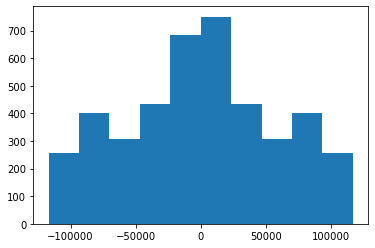

In [22]:
plt.hist(dists.ravel())